# H-Transformer for Item Recommendation in MOBA Games

Vladimir Araujo

## Dependencies

In [1]:
!pip install python-box
!wget https://gist.githubusercontent.com/vgaraujov/47ef44430fdbcc95dcb6c87233c3ef92/raw/97c4608ee2b62c77929784e0d07e05ff27b56ee4/drive_download.py

--2021-11-15 22:43:58--  https://gist.githubusercontent.com/vgaraujov/47ef44430fdbcc95dcb6c87233c3ef92/raw/97c4608ee2b62c77929784e0d07e05ff27b56ee4/drive_download.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2392 (2.3K) [text/plain]
Saving to: ‘drive_download.py’

drive_download.py   100%[===================>]   2.34K  --.-KB/s    in 0s      

2021-11-15 22:43:58 (36.0 MB/s) - ‘drive_download.py’ saved [2392/2392]



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import drive_download

idx = '19oln5xzNGI50KwO7kIP3HADQOeIXMW-R'
drive_download.drive_download(drive, idx)

DOWNLOADING: drive_download/HTransformerV3-2021-10-30_04_30_23-model_best.pth
DOWNLOADING: drive_download/train.py
DOWNLOADING: drive_download/validation.py
DOWNLOADING: drive_download/config.yaml
DOWNLOADING: drive_download/logger.py
DOWNLOADING: drive_download/model_aux.py
DOWNLOADING: drive_download/utils.py
DOWNLOADING: drive_download/torch_aux.py
DOWNLOADING: drive_download/seed.py
DOWNLOADING: drive_download/metrics.py
DOWNLOADING: drive_download/losses.py
DOWNLOADING: drive_download/dataset.py
DOWNLOADING: drive_download/training_all.pkl
DOWNLOADING: drive_download/testing_all.pkl
DOWNLOADING: drive_download/hero_names.csv
DOWNLOADING: drive_download/item_ids.csv


In [4]:
!mv drive_download/* .

In [5]:
import time
import os
import logging
import yaml
from timeit import default_timer as timer

## Libraries
import numpy as np
from box import box_from_file
from pathlib import Path

## Torch
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim

## Custom Imports
from logger import setup_logs
from seed import set_seed
from train import train, snapshot
from validation import validation
from dataset import DotaDataset, DataCollatorForDota
from model_aux import HTransformer
import losses

## Training Model

In [6]:
############ Control Center and Hyperparameter ###############
config = box_from_file(Path('config.yaml'), file_type='yaml')
config.training.logging_dir = '.'
config.dataset.train_data_path = '/content/training_all.pkl'
config.dataset.test_data_path = '/content/testing_all.pkl'
config.dataset.item_path = '/content/item_ids.csv'
config.dataset.champ_path = '/content/hero_names.csv'

In [7]:
run_name = config.model.model_type + time.strftime("-%Y-%m-%d_%H_%M_%S")
# setup logger    
global_timer = timer() # global timer
logger = setup_logs(config.training.logging_dir, run_name) # setup logs
logger.info('### Experiment {} ###'.format(run_name))
logger.info('### Hyperparameter summary below ###\n {}'.format(config))
    
# define if gpu or cpu
use_cuda = not config.training.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
logger.info('===> use_cuda is {}'.format(use_cuda))
# set seed for reproducibility
set_seed(config.training.seed, use_cuda)

### Experiment HTransformer-2021-11-15_23_03_32 ###
### Hyperparameter summary below ###
 {'training': {'logging_dir': '.', 'log_interval': 100, 'epochs': 50, 'batch_size': 100, 'no_cuda': False, 'multigpu': False, 'seed': 42, 'resume_name': False}, 'comet': {'api_key': '6oPfzhw55BucwZ4m8rV62ppyw', 'previous_experiment': False}, 'dataset': {'train_data_path': '/content/training_all.pkl', 'test_data_path': '/content/testing_all.pkl', 'item_path': '/content/item_ids.csv', 'champ_path': '/content/hero_names.csv', 'max_seq_length': 60}, 'model': {'layers1': 1, 'layers2': 1, 'emb_dim': 512, 'n_heads': 4, 'activation': False, 'emb_fusion': 'concat', 'model_type': 'HTransformer', 'loss_fn': 'CrossEntropy', 'user': True, 'pe': True}}
===> use_cuda is True


In [8]:
## Loading the dataset
logger.info('===> loading train and validation dataset')
train_dataset = DotaDataset(config, 'train')
validation_dataset = DotaDataset(config, 'test')

data_collator = DataCollatorForDota(max_length = config.dataset.max_seq_length)

multiplier = torch.cuda.device_count() if not config.training.no_cuda else 1
batch_size = int(config.training.batch_size*multiplier)
train_loader = data.DataLoader(train_dataset,
                               batch_size=batch_size,
                               collate_fn=data_collator,
                               drop_last=True
                              )
validation_loader = data.DataLoader(validation_dataset, 
                                    batch_size=batch_size, # batch 1 for evaluate variable length
                                    collate_fn=data_collator,
                                    drop_last=True
                                   )

config.dataset.n_items = len(train_dataset.id2item)
config.dataset.n_champs = len(train_dataset.id2champ)

===> loading train and validation dataset
Loading features from dataset at /content/training_all.pkl
Loading features from dataset at /content/testing_all.pkl


In [9]:
model = HTransformer(config=config)
# move to device
model.to(device)

# Adam optimizer
optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=2e-4, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
if config.training.resume_name:
    optimizer.load_state_dict(checkpoint['optimizer'])

# create loss function
loss_fn = losses.LossFunction(loss_type=config.model.loss_fn)
    
model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info('### Model summary below ###\n {}'.format(str(model)))
logger.info('===> Model total parameter: {}\n'.format(model_params))

### Model summary below ###
 HTransformer(
  (champion_embedding): Embedding(111, 256)
  (team_embedding): Embedding(2, 256)
  (item_embedding): Linear(in_features=138, out_features=256, bias=True)
  (position_embedding): Embedding(60, 512)
  (transformer_match_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_seq_encoder): Transformer

In [10]:
best_acc = 0
best_loss = np.inf
best_epoch = -1 
step = 0
initial_epoch = 1
    
logger.info('### Training begins at epoch {} and step {} ###'.format(initial_epoch,step))
for epoch in range(initial_epoch, config.training.epochs + 1):
    epoch_timer = timer()
    # Train and validate
    tr_acc, tr_loss, step = train(
        step, 
        model, 
        train_loader, 
        loss_fn, 
        device, 
        optimizer, 
        epoch, 
        config.training.log_interval)
    
    if not epoch % 10:    
        val_acc, val_loss = validation(
            step, 
            model, 
            validation_loader, 
            loss_fn, 
            device)
        # Save
        if val_loss < best_loss: 
            best_loss = min(val_loss, best_loss)
            if torch.cuda.device_count() > 1 and not config.training.no_cuda:
                dict_to_save = model.module.state_dict()
            else:
                dict_to_save = model.state_dict()
            snapshot(config.training.logging_dir, run_name, {
                'epoch': epoch,
                'step_train': step,
                'validation_acc': val_acc,
                'validation_loss': val_loss,
                'state_dict': dict_to_save,
                'optimizer': optimizer.state_dict(),
            })
            best_epoch = epoch

    end_epoch_timer = timer()
    logger.info("#### End epoch {}/{}, elapsed time: {}".format(epoch, config.training.epochs, end_epoch_timer - epoch_timer))
    
## end 
end_global_timer = timer()
logger.info("################## Success #########################")
logger.info("Total elapsed time: %s" % (end_global_timer - global_timer))

### Training begins at epoch 1 and step 0 ###
Train Epoch: 1 [0/184260 (0%)]	Accuracy: 0.0041	Loss: 7.841231
Train Epoch: 1 [10000/184260 (5%)]	Accuracy: 0.0860	Loss: 6.562179
Train Epoch: 1 [20000/184260 (11%)]	Accuracy: 0.1488	Loss: 5.949391
Train Epoch: 1 [30000/184260 (16%)]	Accuracy: 0.1872	Loss: 5.647673
Train Epoch: 1 [40000/184260 (22%)]	Accuracy: 0.2120	Loss: 5.444147
Train Epoch: 1 [50000/184260 (27%)]	Accuracy: 0.2112	Loss: 5.397672
Train Epoch: 1 [60000/184260 (33%)]	Accuracy: 0.2352	Loss: 5.265115
Train Epoch: 1 [70000/184260 (38%)]	Accuracy: 0.2688	Loss: 5.156257
Train Epoch: 1 [80000/184260 (43%)]	Accuracy: 0.2753	Loss: 5.129305
Train Epoch: 1 [90000/184260 (49%)]	Accuracy: 0.2381	Loss: 5.073315
Train Epoch: 1 [100000/184260 (54%)]	Accuracy: 0.2731	Loss: 5.072140
Train Epoch: 1 [110000/184260 (60%)]	Accuracy: 0.2978	Loss: 5.038752
Train Epoch: 1 [120000/184260 (65%)]	Accuracy: 0.2504	Loss: 5.050221
Train Epoch: 1 [130000/184260 (71%)]	Accuracy: 0.2587	Loss: 4.967557
Trai

KeyboardInterrupt: ignored

## Visualization

In [11]:
import numpy as np; np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
import pandas as pd

def open_champs_info(champs_path):
    champs_df = pd.read_csv(champs_path)
    champs_df.drop([106, 111], inplace = True)
    champs_df.drop(['name'], axis = 1, inplace = True)
    champs_df.reset_index(drop=True, inplace=True)
    names = champs_df['localized_name'].tolist()
    dictionary = {names[i] : v for i, v in enumerate(champs_df['hero_id'].tolist())}
    dictionary[0] = 0
    reversed_dictionary = {value : key for (key, value) in dictionary.items()}
    return dictionary, reversed_dictionary

_, mapping = open_champs_info(config.dataset.champ_path)

In [13]:
run_name = 'HTransformerV3-2021-10-30_04_30_23'
logger.info('===> loading a checkpoint')
checkpoint = torch.load('{}/{}-{}'.format(config.training.logging_dir, run_name, 'model_best.pth'))
model.load_state_dict(checkpoint['state_dict'])

===> loading a checkpoint


<All keys matched successfully>

In [14]:
validation_loader = data.DataLoader(validation_dataset, 
                                    batch_size=1, # batch 1 for evaluate variable length
                                    collate_fn=data_collator,
                                    drop_last=True,
                                    shuffle=True
                                   )

In [15]:
champs, items, target, attn_mask = next(iter(validation_loader))

In [16]:
output, attn_1, attn_2 = model(champs.cuda(), items.cuda())

In [17]:
data_1=attn_1.detach().cpu().numpy()
data_2=attn_2.squeeze(0).detach().cpu().numpy()

In [18]:
heros = champs.detach().cpu().squeeze(0).tolist()
name_heros = []
for i in heros:
    name_heros.append(mapping[int(i)])

Text(0.5, 32.99999999999995, 'Heros')

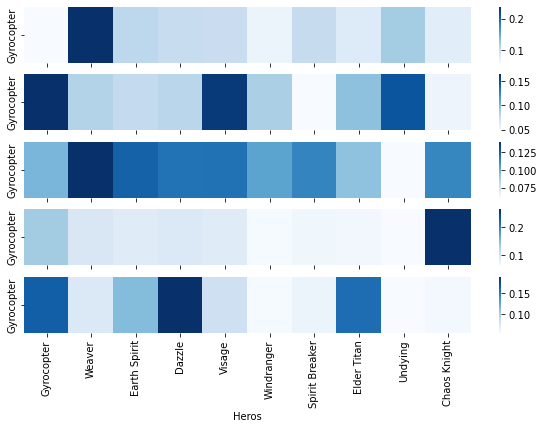

In [19]:
fig,axn = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(10,6))

aux = 2
for i, ax in enumerate(axn.flat):
    df = pd.DataFrame(data_1[i+aux], index=name_heros, columns=name_heros)
    df.drop(labels=name_heros[1:], axis=0, inplace=True)
#     ax.set_title("Step "+str(i+aux))
    sns.heatmap(df, ax=ax, cmap="Blues", cbar=True)
plt.xlabel("Heros")

Text(51.0, 0.5, 'Sequence Step')

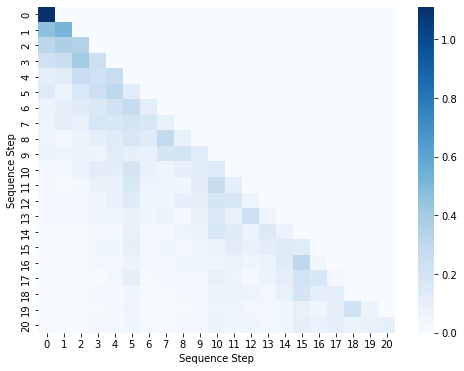

In [20]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(data_2, cmap="Blues")
plt.xlabel("Sequence Step")
plt.ylabel("Sequence Step")